# Ising Model (incl. Monte Carlo)

## Simulation initialisation & results

2.06115362244e-09
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1.]
 [-1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1.  1.]
 [-1. -1.  1. -1. -1.]]
Cluster 0 : [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 1], [1, 0], [2, 1], [4, 2], [3, 2], [3, 3], [3, 4], [3, 0]]
Cluster 1 : [[2, 0], [2, 4], [2, 3], [2, 2], [1, 3], [1, 4]]
Cluster 2 : [[4, 0], [4, 1], [3, 1], [4, 4], [4, 3]]


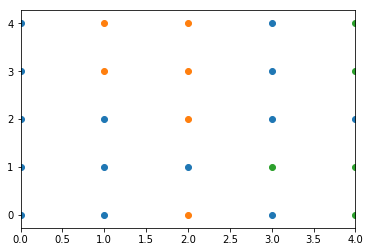

In [58]:
%matplotlib inline
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Simulation initialisation
sim = SimpleNamespace(time_steps = 1,
                      L = 5,
                      T = 1,
                      dT = 0,
                      h = 0,
                      dh = 0,
                      J = 10,
                      kb = 1,
                      spin_init = 'random')
sim.spin_site_total_number = sim.L**2
sim.MCS = sim.L**2
sim.beta = 1/(sim.kb*sim.T)

results, grid_coordinates, islands = IM_sim(sim)



In [57]:
def IM_sim(self):
    
    grid_coordinates, spin_site_numbers = grid_init(self)
    grid_spins = assign_spin(self)
    
    magnitization_total, T_total, h_total, energy_total = matrix_init(self)
    energy_i = system_energy(grid_coordinates, grid_spins, spin_site_numbers)
    
    for i, t in enumerate(range(self.time_steps)):
        energy_total[i] = energy_i    
        magnitization_total[i] = magnetisation(self, grid_spins)
        T_total[i] = self.T 
        h_total[i] = self.h

        grid_spins, energy_i = spin_flip_random(self, grid_coordinates, grid_spins, energy_i)
        system_energy(grid_coordinates, grid_spins, spin_site_numbers)
        sim.T += sim.dT
        sim.h += sim.dh
    bonds = bond_eval(self, grid_spins)
    islands = identify_islands(self, grid_coordinates, bonds)
    # This part is for debugging purposes
    print(grid_spins)
    
    for i, clus in enumerate(islands):
        print('Cluster', i,':', clus)
    visualize_islands(islands)
    # Upuntil here
    
    results = SimpleNamespace()
    results.energy = energy_total
    results.magnitization = magnitization_total
    results.temperature = T_total
    results.magnetic_field = h_total
    results.bonds = bonds
    
    return results, grid_coordinates, islands


## Plotting

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(range(sim.time_steps), results.energy, '-')
plt.xlabel('time_steps')
plt.ylabel('E')

ax2 = fig.add_subplot(222)
ax2.plot(range(sim.time_steps), results.magnitization, '-') # m vs time_steps
# ax2.plot(T_total, magnitization_total[:-1], '-') # m vs T
#ax2.plot([1/0.44, 1/0.44],[-1,1]) # Critical point for J/k_bT = 0.44
plt.ylim([-1.1,1.1])
#plt.xlabel('k_bT/J')
plt.xlabel('time_steps')
plt.ylabel('m')

ax3 = fig.add_subplot(223)
ax3.plot(range(sim.time_steps), results.temperature, '-')
plt.xlabel('time_steps')
plt.ylabel('T')

ax4 = fig.add_subplot(224)
ax4.plot(range(sim.time_steps), results.magnetic_field, '-')
plt.xlabel('time_steps')
plt.ylabel('h')


plt.tight_layout()
fig = plt.gcf()

plt.show()



## Function definitions

In [9]:
def matrix_init(self):
    magnitization_total = np.zeros([self.time_steps, 1])
    T_total = np.zeros([self.time_steps, 1])
    h_total = np.zeros([self.time_steps, 1])
    energy_total = np.zeros([self.time_steps, 1])
    
    return magnitization_total, T_total, h_total, energy_total


def grid_init(self):
    grid_x, grid_y = [range(self.L), range(self.L)]
    grid_coordinates = np.meshgrid(grid_x, grid_y) 
    grid_coordinates = np.reshape(grid_coordinates,(2,-1))
    spin_site_numbers = range(self.spin_site_total_number)
    
    return grid_coordinates, spin_site_numbers


def grid_plot(x, y, S):
    image = plt.imshow(S, extent=(x.min(), x.max(), y.max(), y.min()), interpolation='nearest', cmap=cm.plasma)
    plt.clim(-1,1)
    plt.xlabel('y')
    plt.ylabel('x')
    
    return image


def assign_spin(self):
    if self.spin_init == 'random':
        grid_spins = rnd.rand(self.L, self.L)
        grid_spins[grid_spins >= 0.5] = 1
        grid_spins[grid_spins <  0.5] = -1
        
    elif self.spin_init == 'up':
        grid_spins = np.ones([self.L,self.L], dtype= int)
        
    elif self.spin_init == 'down':
        grid_spins = -1*np.ones([self.L,self.L], dtype= int)
        
    return grid_spins


def spin_site_energy(self, spin_site_x, spin_site_y, grid_spins):
    spin_site_energy = 0
    
    spin_neigbour_x = (spin_site_x + np.array([1, 0, -1, 0]))%(self.L)
    spin_neigbour_y = (spin_site_y + np.array([0, -1, 0, 1]))%(self.L)
    
    for i in range(np.size(spin_neigbour_x)):
        spin_value_center = grid_spins[spin_site_x, spin_site_y]
        spin_value_neighbour = grid_spins[spin_neigbour_x[i], spin_neigbour_y[i]]

        spin_site_energy += -self.J*spin_value_center*spin_value_neighbour - self.h*spin_value_center
        
    return spin_site_energy 


def system_energy(grid_coordinates, grid_spins, spin_site_numbers):
    '''Gives the energy of the system
    
    Parameters
    ----------
    grid_coordinates : 2D array (dim, L*L)
        containing the x coordinates of the spins        
    grid_spins : 2D array (L, L)
        containing al the spin values within the grid        
    spin_site_numbers: ?????????????????????????????????????????????????????????????????????????????
        
    Returns
    -------
    sys_energy: float
        
    '''
    
    sys_energy = 0
    for spin_site_number in spin_site_numbers:
        spin_site_x = grid_coordinates[0][spin_site_number]
        spin_site_y = grid_coordinates[1][spin_site_number]
        sys_energy += spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins)
    sys_energy = sys_energy/2 # To counter double counting of the links
    
    return sys_energy


def spin_flip_accept(self, spin_flip_energy_delta):
    '''If this difference, spin_flip_energy_delta (dE), is < 0 this flip is accepted,
    if dE > 0 this flip is accepted with probability e^-dE/K_bT.
    
    Parameters
    ----------
    self : NameSpace
        contains all the simulation parameters
    spin_flip_energy_delta : float
        containing the energy difference upon a spin flip
        
    Returns
    -------
    boolean
        True if flip is accepted, false if rejected
    '''    
     
    return rnd.binomial(1, np.exp(-spin_flip_energy_delta/(self.kb*self.T))) == 1
    
def spin_flip_random(self, grid_coordinates, grid_spins, E_system):
    '''Uses an algorithm where is spin is chosen at random, flipped, the energy 
    difference is checked. If this difference is < 0 this flip is accepted,
    if dE > 0 this flip is accepted with probability e^-dE/K_bT.
    
    Parameters
    ----------
    self : NameSpace
        contains all the simulation parameters
    grid_coordinates : 2D array (dim, L*L)
        containing the x coordinates of the spins
    grid_spins : 2D array (L, L)
        containing al the spin values within the grid
    E_system: float
        current value of the system energy

    Returns
    -------
    grid_spins : 2D array (L, L)
        containing al the spin values 
    E_system: float 
        energy of the system, which may have changed upon spin flip
    '''    
    spin_site_number = rnd.randint(0, self.spin_site_total_number)
    spin_site_x = grid_coordinates[0][spin_site_number]
    spin_site_y = grid_coordinates[1][spin_site_number]
       
    spin_site_energy_pre_flip = spin_site_energy(self, spin_site_x, spin_site_y, grid_spins)
    grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
    spin_site_energy_post_flip = spin_site_energy(self, spin_site_x, spin_site_y, grid_spins) 
    
    spin_flip_energy_delta = spin_site_energy_post_flip - spin_site_energy_pre_flip
        
    if spin_flip_energy_delta <= 0:
        E_system += spin_flip_energy_delta
        
    elif spin_flip_energy_delta > 0:
        
        if  spin_flip_accept(sim, spin_flip_energy_delta):
            E_system += spin_flip_energy_delta
            
        else:  
            grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
            
    return grid_spins, E_system


def bond_eval(self, grid_spins):
    '''Goes over all the spins in the system and checks the bonds, 
    if they are opposite the bond is set to 0 if they are equal the 
    bond is set to infinity with probability (1 - e^-2J/(k_bT)).
    
    Parameters
    ----------
    self : NameSpace
        contains all the simulation parameters
    grid_spins : 2D array (L, L)
        containing al the spin values within the grid  


    Returns
    -------
    bonds : 3D array (2, L, L)
        contains al the bonds present in the system. The first 2D array
        gives the horizontal bonds (Element (i,j) gives the relation
        between spin_site (i,j) and (i,j+1). When j+1 does not exist it
        refers to (i,0) which illustrates the periodic BCs.) and the
        second 2D array gives the vertical bonds (Element  (i,j) gives
        the relation between spin_site (i,j) and (i+1,j). When i+1 does
        not exist it refers to (0,j) which illustrates the periodic BCs.).
    '''
    
    bonds = np.zeros((2, self.L, self.L,),dtype=float)
    chance_value = np.exp(-2*self.J/(self.kb*self.T))
    
    print(chance_value)

    
    delta_spin_hor = np.abs(grid_spins+np.roll(grid_spins,-1,axis=1))/2 # Divided by 2 to normalise
    nz_delta_spin_hor = np.asarray(np.nonzero(delta_spin_hor)) # Gives array with indices for non-zero elements

    delta_spin_ver = np.abs(grid_spins+np.roll(grid_spins,-1,axis=0))/2 # Divided by 2 to normalise
    nz_delta_spin_ver = np.asarray(np.nonzero(delta_spin_ver)) # Gives array with indices for non-zero elements

    for i in range(np.shape(nz_delta_spin_hor)[1]):
        if rnd.binomial(1, chance_value) == 1:
            bonds[0, nz_delta_spin_hor[0,i], nz_delta_spin_hor[1,i]] = 0
        else:
            bonds[0, nz_delta_spin_hor[0,i], nz_delta_spin_hor[1,i]] = np.inf

    for j in range(np.shape(nz_delta_spin_ver)[1]):
        if rnd.binomial(1, chance_value) == 1:
            bonds[1, nz_delta_spin_ver[0,j], nz_delta_spin_ver[1,j]] = 0
        else:
            bonds[1, nz_delta_spin_ver[0,j], nz_delta_spin_ver[1,j]] = np.inf
    
    return bonds

def back_track(self, x, y, bonds, not_visited, cluster):
    '''Checks the neighbours of the spin, if they are 
    equal this functions jumps over to that spin and 
    repeats itself. The spins that are already visited 
    are skipped. Everytime an equal bond is found, this
    spind is added to the cluster.'''
    
    if not_visited[x, y]:
        not_visited[x, y] = False
        cluster.append([x, y])
        
        if bonds[0][x][y] == np.inf:
            n_x = x
            n_y = (y + 1)%self.L
            cluster = back_track(self, n_x, n_y, bonds, not_visited, cluster)
            
        if bonds[0][x][(y - 1)%self.L] == np.inf:
            n_x = x
            n_y = (y - 1)%self.L
            cluster = back_track(self, n_x, n_y, bonds, not_visited, cluster)
            
        if bonds[1][x][y] == np.inf:
            n_x = (x + 1)%self.L
            n_y = y
            cluster = back_track(self, n_x, n_y, bonds, not_visited, cluster)
            
        if bonds[1][(x - 1)%self.L][y] == np.inf:
            n_x = (x - 1)%self.L
            n_y = y
            cluster = back_track(self, n_x, n_y, bonds, not_visited, cluster)
            
    return cluster     


def identify_islands(self, grid_coordinates, bonds):
    '''Functions that idintifies al the clusters, "islands", 
    using the back_track function. The function runs over all 
    spins. Everytime a new cluster is identified it gets added
    to the total cluster list.'''
    
    islands = []
    not_visited = np.reshape(np.ones((self.L, self.L), dtype= bool),(self.L, self.L))
    spin_site_numbers = range(self.spin_site_total_number)
    
    for i in spin_site_numbers:
        cluster = []
        spin_site_x = grid_coordinates[0][i]
        spin_site_y = grid_coordinates[1][i]
        cluster = back_track(self, spin_site_x, spin_site_y, bonds, not_visited, cluster)
        if cluster != []:
            islands.append(cluster)
            
    return islands


def magnetisation(self, grid_spins):
    magnetisation = np.sum(np.sum(grid_spins,axis=0))/self.spin_site_total_number
    
    return magnetisation


'''
def specific_heat(sim, energy_total):
    # Need to implement function which selects E from energy calculated such that the values in E are uncorrelated.
    E = energy_total[]
    
    # Computation of the specific heat and its error
    f = self.beta**2*self.kb/self.spin_site_total_number
    Cv = f*np.var(E)
    Cv_std = f*std(E)
    
    return Cv, Cv_std

def magnetic_susceptibility(sim, magnetisation):
    # Need to implement function which selects m from magnetisation calculated such that the values in magnetisation are uncorrelated.
    m = magnetisation[]
    
    # Computation of the magnetic susceptibility and its error
    f = self.beta*self.spin_site_total_number
    chi = f*np.var(m)
    chi_std  = f*std(m)
    
    return chi, chi_std
'''


'\ndef specific_heat(sim, energy_total):\n    # Need to implement function which selects E from energy calculated such that the values in E are uncorrelated.\n    E = energy_total[]\n    \n    # Computation of the specific heat and its error\n    f = self.beta**2*self.kb/self.spin_site_total_number\n    Cv = f*np.var(E)\n    Cv_std = f*std(E)\n    \n    return Cv, Cv_std\n\ndef magnetic_susceptibility(sim, magnetisation):\n    # Need to implement function which selects m from magnetisation calculated such that the values in magnetisation are uncorrelated.\n    m = magnetisation[]\n    \n    # Computation of the magnetic susceptibility and its error\n    f = self.beta*self.spin_site_total_number\n    chi = f*np.var(m)\n    chi_std  = f*std(m)\n    \n    return chi, chi_std\n'

## Code in development

(4, 0)

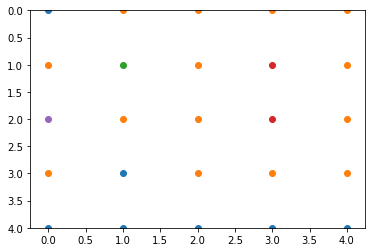

In [56]:
def visualize_islands(islands):
    # Visualize spin islands
    x_coord = []
    y_coord = []

    for i in islands:
        x_temp = []
        y_temp = []
        for x, y in i:
            x_temp.append(x)
            y_temp.append(y)

        x_coord.append(x_temp)     
        y_coord.append(y_temp)  

    for i, x in enumerate(x_coord):
        y = y_coord[i]
        plt.scatter(x, y)
    plt.ylim([4, 0])

In [ ]:
# Testing bond_eval function
grid_coordinates, spin_site_numbers = grid_init(sim)
grid_spins = assign_spin(sim)

chance_value = np.exp(-2*sim.J/(sim.kb*sim.T))

delta_spin_hor = np.abs(grid_spins+np.roll(grid_spins,-1,axis=1))/2 # Divided by 2 to normalise
# Element (i,j) gives the relation between spin_site (i,j) and (i,j+1). When j+1 does not exist it refers to (i,0) which illustraties the periodic BCs.
nz_delta_spin_hor = np.asarray(np.nonzero(delta_spin_hor)) # Gives array with indices for non-zero elements

delta_spin_ver = np.abs(grid_spins+np.roll(grid_spins,-1,axis=0))/2 # Divided by 2 to normalise
# Element  (i,j) gives the relation between spin_site (i,j) and (i+1,j). When i+1 does not exist it refers to (0,j) which illustraties the periodic BCs.
nz_delta_spin_ver = np.asarray(np.nonzero(delta_spin_ver)) # Gives array with indices for non-zero elements

bonds = np.zeros((2, sim.L, sim.L,),dtype=float) # L x L due to grid size and 2 for vertical and horizontal case. (1st hor, 2nd ver)
bonds_init = np.zeros((2, sim.L, sim.L,),dtype=float)

for i in range(np.shape(nz_delta_spin_hor)[1]):
    if rnd.binomial(1, 0.3) == 1:
        bonds[0, nz_delta_spin_hor[0,i], nz_delta_spin_hor[1,i]] = 0
    else:
        bonds[0, nz_delta_spin_hor[0,i], nz_delta_spin_hor[1,i]] = np.inf

for j in range(np.shape(nz_delta_spin_ver)[1]):
    if rnd.binomial(1, 0.3) == 1:
        bonds[1, nz_delta_spin_ver[0,j], nz_delta_spin_ver[1,j]] = 0
    else:
        bonds[1, nz_delta_spin_ver[0,j], nz_delta_spin_ver[1,j]] = np.inf


In [ ]:
# Visual check bond_eval function
print('delta_spin_hor')
print(delta_spin_hor)
print(np.shape(delta_spin_hor))
print('------------------------')
print(nz_delta_spin_hor)
print(np.shape(nz_delta_spin_hor))
#print(np.shape(nz_delta_spin_hor)[1])
print('------------------------')
print('delta_spin_ver')
print(delta_spin_ver)
print(np.shape(delta_spin_ver))
print('------------------------')
print(nz_delta_spin_ver)
print(np.shape(nz_delta_spin_ver))
#print(np.shape(nz_delta_spin_hor)[1])
print('------------------------')
print('Bonds_init')
print(bonds_init)
print('------------------------')
print('Bonds_after')
print(bonds)

## Animation function

In [ ]:
# Needs to be called before matplotlib is imported
%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button, RadioButtons


fig2 = plt.figure()

im = plt.imshow(grid_spins, extent=(grid_coordinates_x.min(), grid_coordinates_x.max(), 
                                    grid_coordinates_y.max(), grid_coordinates_y.min()), 
                interpolation='nearest', cmap=cm.plasma, animated=True)
plt.clim(-1, 1)
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
axis_color = 'lightgoldenrodyellow'

ax = fig2.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig2.subplots_adjust(left=0.25, bottom=0.3)


# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
m_slider_ax  = fig2.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
m_slider = Slider(m_slider_ax, 'h', -10.0, 10.0, valinit=sim.h)


# Draw another slider
T_slider_ax = fig2.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
T_slider = Slider(T_slider_ax, 'T', 0.1, 100.0, valinit=sim.T)


# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    global sim
    sim.h = m_slider.val
    sim.T = T_slider.val

m_slider.on_changed(sliders_on_changed)
T_slider.on_changed(sliders_on_changed)


# Add a button for resetting the parameters
reset_button_ax = fig2.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')


def reset_button_on_clicked(mouse_event):
    T_slider.reset()
    m_slider.reset()

reset_button.on_clicked(reset_button_on_clicked)


def updatefig(*args):
    global sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i
    grid_spins, energy_i = spin_flip(sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i)
    im.set_array(grid_spins)
    
    return im,


ani = animation.FuncAnimation(fig2, updatefig, interval=1, blit=True) # for save animation: + ,frames=1000)
#ani.save('animation.mp4')


## Redundant (for now)

In [ ]:
'''
def acceptance_prob(self):
    ap = np.exp(-2*beta*self.J*np.array([4, 2, 0, -2, -4])) # 4 (pairs)equal, 3 equal, 2 equal, 1 equal, 0 equal
    return ap
    
'''